In [1]:
import os
import pandas as pd
from tqdm import tqdm

# Define dataset paths
train_dir = '/kaggle/input/raf-db/DATASET/train'
test_dir = '/kaggle/input/raf-db/DATASET/test'

def count_images_in_folders(base_dir):
    """
    Counts the number of images in each class folder within a given dataset directory.
    Shows progress using tqdm.
    
    :param base_dir: Path to the dataset (train/test directory)
    :return: Dictionary with class names as keys and image counts as values
    """
    class_counts = {}
    total_images = 0
    
    # Get list of class directories
    class_dirs = sorted(os.listdir(base_dir))  # Sorted for consistency
    
    # Create progress bar for class processing
    for class_name in tqdm(class_dirs, desc="Processing classes", unit="class"):
        class_path = os.path.join(base_dir, class_name)
        
        if os.path.isdir(class_path):  # Ensure it's a directory
            # Get list of images and count them
            images = os.listdir(class_path)
            num_images = len(images)
            class_counts[class_name] = num_images
            total_images += num_images
            
    return class_counts, total_images

# Show progress bar for train set processing
print("\n🔄 Processing Training Set:")
train_counts, train_total = count_images_in_folders(train_dir)

# Show progress bar for test set processing
print("\n🔄 Processing Test Set:")
test_counts, test_total = count_images_in_folders(test_dir)

# Convert to DataFrame for better visualization
df_summary = pd.DataFrame({
    "Class": list(train_counts.keys()),
    "Train Images": list(train_counts.values()),
    "Test Images": [test_counts.get(cls, 0) for cls in train_counts.keys()]  # Handle missing classes
})

# Add totals row
df_summary.loc[len(df_summary)] = ["Total", train_total, test_total]

# Display the summary
print("\n📊 Dataset Summary:\n")
print(df_summary.to_string(index=False))


🔄 Processing Training Set:


Processing classes: 100%|██████████| 7/7 [00:00<00:00, 42.61class/s]



🔄 Processing Test Set:


Processing classes: 100%|██████████| 7/7 [00:00<00:00, 80.50class/s]


📊 Dataset Summary:

Class  Train Images  Test Images
    1          1290          329
    2           281           74
    3           717          160
    4          4772         1185
    5          1982          478
    6           705          162
    7          2524          680
Total         12271         3068


Found 3068 images belonging to 7 classes.

Fold 1/5
Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 203s 605ms/step - accuracy: 0.3850 - loss: 1.7451 - val_accuracy: 0.4645 - val_loss: 1.4649 - learning_rate: 0.0010
Epoch 2/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 136s 434ms/step - accuracy: 0.4598 - loss: 1.5161 - val_accuracy: 0.4886 - val_loss: 1.4120 - learning_rate: 0.0010
Epoch 3/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 136s 435ms/step - accuracy: 0.4843 - loss: 1.4436 - val_accuracy: 0.5212 - val_loss: 1.3379 - learning_rate: 0.0010
Epoch 4/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 139s 442ms/step - accuracy: 0.4849 - loss: 1.4190 - val_accuracy: 0.5020 - val_loss: 1.3575 - learning_rate: 0.0010
Epoch 5/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 137s 437ms/step - accuracy: 0.4922 - loss: 1.3982 - val_accuracy: 0.5126 - val_loss: 1.3744 - learning_rate: 0.0010
Epoch 6/200
307/307 ━━━━━━━━

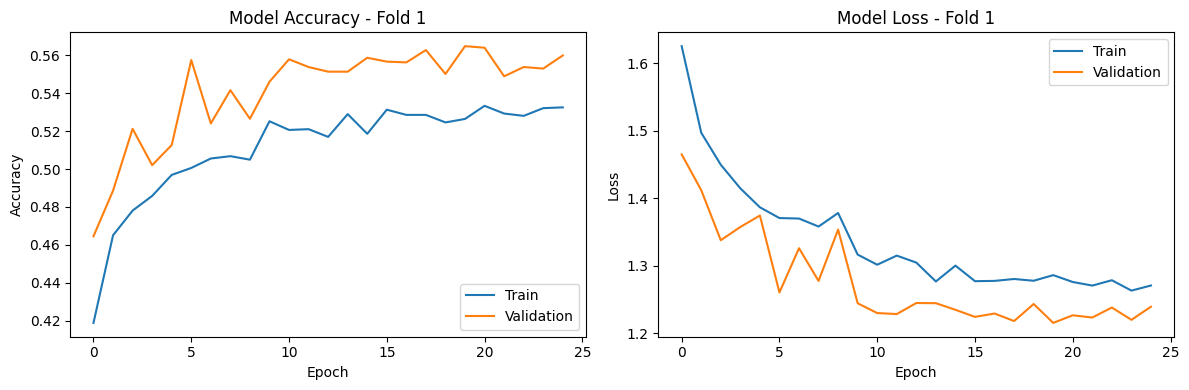

96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 0.5697 - loss: 1.2457
Fold 1 Test Accuracy: 0.5727
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step


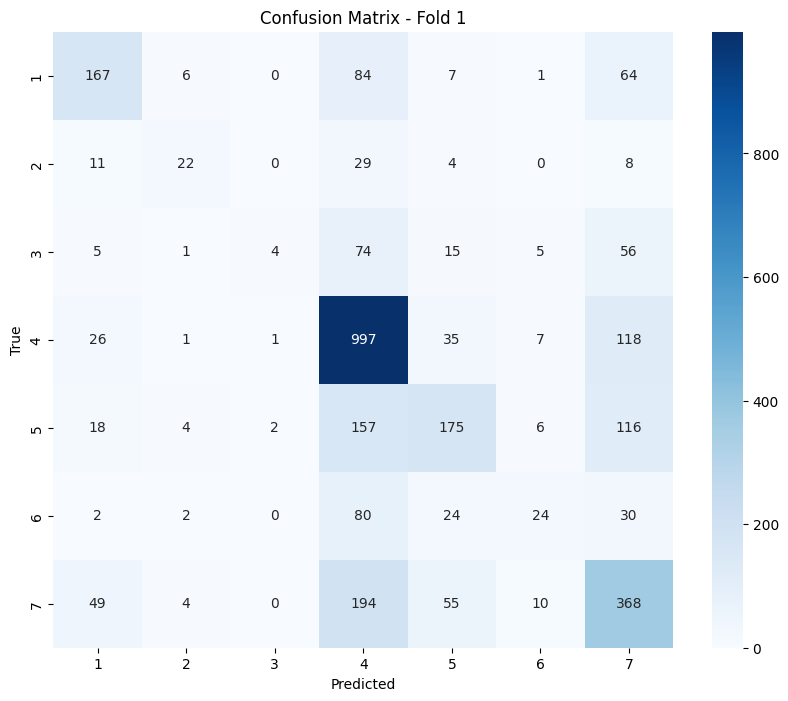


Classification Report for Fold 1:
              precision    recall  f1-score   support

           1       0.60      0.51      0.55       329
           2       0.55      0.30      0.39        74
           3       0.57      0.03      0.05       160
           4       0.62      0.84      0.71      1185
           5       0.56      0.37      0.44       478
           6       0.45      0.15      0.22       162
           7       0.48      0.54      0.51       680

    accuracy                           0.57      3068
   macro avg       0.55      0.39      0.41      3068
weighted avg       0.56      0.57      0.54      3068


Fold 2/5
Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.
Epoch 1/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 151s 453ms/step - accuracy: 0.3922 - loss: 1.7150 - val_accuracy: 0.4943 - val_loss: 1.4444 - learning_rate: 0.0010
Epoch 2/200
307/307 ━━━━━━━━━━━━━━━━━━━━ 133s 425ms/step - accuracy: 0.4733 - loss: 1.4758 - val_accuracy: 0.5037 - v

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

class EmotionDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, datagen, batch_size, target_size, class_mode='categorical', subset=None, shuffle=True, **kwargs):
        super().__init__(**kwargs)  # Properly initialize parent class
        self.generator = datagen.flow_from_directory(
            directory,
            target_size=target_size,
            batch_size=batch_size,
            class_mode=class_mode,
            subset=subset,
            shuffle=shuffle
        )
    
    def __len__(self):
        return len(self.generator)
    
    def __getitem__(self, idx):
        return self.generator[idx]

def build_model(image_size, num_classes=7):
    base_model = InceptionV3(
        weights='imagenet', 
        include_top=False, 
        input_shape=image_size + (3,)
    )
    
    # Freeze initial layers
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)  # Increased dropout for better regularization
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def plot_training_metrics(history, fold):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'Model Accuracy - Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'Model Loss - Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def main():
    # Configuration
    data_dir = '/kaggle/input/raf-db/DATASET/train'
    test_data_dir = '/kaggle/input/raf-db/DATASET/test'
    batch_size = 32
    image_size = (224, 224)
    k_folds = 5
    epochs = 200
    
    # Data Augmentation
    train_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )
    
    test_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
    )
    
    # Create custom test generator
    test_generator = EmotionDataGenerator(
        test_data_dir,
        test_datagen,
        batch_size=batch_size,
        target_size=image_size,
        class_mode='categorical',
        shuffle=False
    )
    
    # K-Fold Cross-validation
    fold_scores = []
    
    for fold in range(k_folds):
        print(f'\nFold {fold + 1}/{k_folds}')
        
        # Create custom generators for this fold
        train_generator = EmotionDataGenerator(
            data_dir,
            train_datagen,
            batch_size=batch_size,
            target_size=image_size,
            class_mode='categorical',
            subset='training'
        )
        
        val_generator = EmotionDataGenerator(
            data_dir,
            train_datagen,
            batch_size=batch_size,
            target_size=image_size,
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )
        
        # Build and train model
        model = build_model(image_size)
        
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=3,
                min_lr=1e-6,
                verbose=1
            )
        ]
        
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator,
            callbacks=callbacks,
            verbose=1
        )
        
        # Plot training metrics
        plot_training_metrics(history, fold + 1)
        
        # Evaluate on test set
        test_loss, test_acc = model.evaluate(test_generator, verbose=1)
        fold_scores.append(test_acc)
        print(f"Fold {fold + 1} Test Accuracy: {test_acc:.4f}")
        
        # Generate predictions and metrics
        y_pred = np.argmax(model.predict(test_generator), axis=1)
        true_labels = test_generator.generator.classes
        class_labels = list(test_generator.generator.class_indices.keys())
        
        # Confusion Matrix
        conf_mat = confusion_matrix(true_labels, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            conf_mat,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels
        )
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"Confusion Matrix - Fold {fold + 1}")
        plt.show()
        
        # Classification Report
        print(f"\nClassification Report for Fold {fold + 1}:")
        print(classification_report(
            true_labels,
            y_pred,
            target_names=class_labels,
            zero_division=0  # Handle zero division explicitly
        ))
        
        # Save model
        model.save(f'emotion_model_fold{fold + 1}.h5')
    
    # Print final results
    print("\nCross-validation Results:")
    print(f"Mean Accuracy: {np.mean(fold_scores):.4f} (±{np.std(fold_scores):.4f})")

if __name__ == "__main__":
    main()